In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D , Dropout
from tensorflow.keras.utils import to_categorical
from pyspark.sql import SparkSession

2024-04-12 11:38:21.235676: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 11:38:21.235742: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 11:38:21.272497: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-12 11:38:21.358681: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 11:38:22.181575: W tensorflow/compiler/tf2

In [2]:
spark = SparkSession.builder.appName('Deepfake_Detection_using_Distributed_Learning').master("yarn").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/12 11:39:01 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [3]:
spark.sparkContext

<SparkContext master=yarn appName=Deepfake_Detection_using_Distributed_Learning>

In [4]:
df1 = spark.read.csv("/user/hadoop/input_data/112x112_2k_deepfake_images.csv")

df2  = spark.read.csv("/user/hadoop/input_data/112x112_500_test_deepfake_images.csv")

In [5]:
train=df1.toPandas().values

24/04/12 11:39:35 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/04/12 11:39:35 WARN DAGScheduler: Broadcasting large task binary with size 1446.2 KiB


In [6]:
test=df2.toPandas().values

24/04/12 11:42:26 WARN DAGScheduler: Broadcasting large task binary with size 1446.2 KiB


In [7]:
trainX = train[:, :-1].reshape(train.shape[0],112, 112, 1).astype( 'float32' )
X_train = trainX / 255.0

y_train = train[:,-1]


# Reshape and normalize test data
testX = test[:,:-1].reshape(test.shape[0],112, 112, 1).astype( 'float32' )
X_test = testX / 255.0

y_test = test[:,-1]

In [8]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

In [9]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

def mbConv_block(
    input_data,repeat_num, kernel_size,input_filter,output_filter,expand_ratio,se_ratio,strides, drop_ratio):


    # expansion phase (1,1)
    expanded_filter =  input_filter * expand_ratio
    x = tf.keras.layers.Conv2D(expanded_filter, 1,  padding='same',  use_bias=False)(input_data)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('swish')(x)

    # Depthwise convolution phase (k,k)
    x = tf.keras.layers.DepthwiseConv2D(kernel_size, strides,  padding='same',  use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('swish')(x)

    # Squeeze and excitation phase (1,1)
    squeezed_filter = max(1, int(input_filter * se_ratio))
    se = tf.keras.layers.GlobalAveragePooling2D()(x)
    se = tf.keras.layers.Reshape((1, 1, expanded_filter))(se)
    se = tf.keras.layers.Conv2D(squeezed_filter,1)(se)
    se = tf.keras.layers.Activation('swish')(se)
    se = tf.keras.layers.Conv2D(expanded_filter,1, activation='sigmoid')(se)
    x = tf.keras.layers.multiply([x, se])

    # Output phase (1,1)
    x = tf.keras.layers.Conv2D(output_filter, 1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if repeat_num == 1:
        pass
    else:
        x = tf.keras.layers.Dropout(drop_ratio)(x)

    return x


def Model():

    model_input =  tf.keras.layers.Input(shape = (112,112,1))

    # stem
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same',strides = (2,2))(model_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('swish')(x)

    # mbConv_blocks
    MBConv1_1 = mbConv_block(x,3,1,32,16,1,0.25,1,0.2)

    MBConv6_2_1 = mbConv_block(MBConv1_1,3,1,16,24,6,0.25,2,0.2)
    MBConv6_2_2 = mbConv_block(MBConv1_1,3,2,16,24,6,0.25,2,0.2)
    x = tf.keras.layers.add([MBConv6_2_1, MBConv6_2_2])

    MBConv6_3_1 = mbConv_block(x,5,1,24,40,6,0.25,2,0.2)
    MBConv6_3_2 = mbConv_block(x,5,2,24,40,6,0.25,2,0.2)
    x = tf.keras.layers.add([MBConv6_3_1, MBConv6_3_2])

    MBConv6_4_1 = mbConv_block(x,3,1,40,80,6,0.25,2,0.2)
    MBConv6_4_2 =  mbConv_block(x,3,2,40,80,6,0.25,2,0.2)
    MBConv6_4_3 =  mbConv_block(x,3,3,40,80,6,0.25,2,0.2)
    x = tf.keras.layers.add([MBConv6_4_1, MBConv6_4_2, MBConv6_4_3])

    MBConv6_5_1 = mbConv_block(x,5,1,80,112,6,0.25,1,0.2)
    MBConv6_5_2 =  mbConv_block(x,5,2,80,112,6,0.25,1,0.2)
    MBConv6_5_3 =  mbConv_block(x,5,3,80,112,6,0.25,1,0.2)
    x = tf.keras.layers.add([MBConv6_5_1, MBConv6_5_2, MBConv6_5_3])


    #MBConv6_6_1 = mbConv_block(x,5,1,112,192,6,0.25,2,0.2)
    #MBConv6_6_2 =  mbConv_block(x,5,2,112,192,6,0.25,2,0.2)
    #MBConv6_6_3 =  mbConv_block(x,5,3,112,192,6,0.25,2,0.2)
    #MBConv6_6_4 =  mbConv_block(x,5,4,112,192,6,0.25,2,0.2)
    #x = tf.keras.layers.add([MBConv6_6_1, MBConv6_6_2, MBConv6_6_3, MBConv6_6_4])

    MBConv6_7 = mbConv_block(x,3,1,112,192,6,0.25,1,0.2)

    # output
    pool = tf.keras.layers.GlobalAveragePooling2D()(x)
    output = tf.keras.layers.Dense(2, activation='softmax')(pool)


    model = tf.keras.Model(model_input, output)

    return model

## Train ##

model = Model()




In [10]:
model.summary()
#Total params: 1709102 (6.52 MB)
#Trainable params: 1687598 (6.44 MB)
#Non-trainable params: 21504 (84.00 KB)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 112, 112,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 56, 56,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 56, 56,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      1,024 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 56, 56,    │         32 │ activation_1[0][… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ activation_2[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 32)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 1, 1, 8)   │        264 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 1, 1, 8)   │          0 │ conv2d_2[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 1, 1, 32)  │        288 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 56, 56,    │          0 │ activation_2[0][… │
│                     │ 32)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │        512 │ multiply[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │         64 │ conv2d_4[0][0]  

 Total params: 507,064 (1.93 MB)

 Trainable params: 494,872 (1.89 MB)

 Non-trainable params: 12,192 (47.62 KB)

In [11]:
model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=["accuracy"])
hist = model.fit(X_train, y_train, epochs=50,shuffle=True)
#tf.keras.optimizers.Adam(learning_rate=1e-3)
#loss: 0.2671 - accuracy: 0.8895

Epoch 1/50


2024-04-12 11:45:07.655177: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 100402176 exceeds 10% of free system memory.
2024-04-12 11:45:23.118199: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 38535168 exceeds 10% of free system memory.
2024-04-12 11:45:23.118246: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 38535168 exceeds 10% of free system memory.
2024-04-12 11:45:23.138788: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 38535168 exceeds 10% of free system memory.
2024-04-12 11:45:23.153637: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 38535168 exceeds 10% of free system memory.


63/63 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.5616 - loss: 0.8683
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.6469 - loss: 0.6474
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.7147 - loss: 0.5584
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.7676 - loss: 0.4751
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.7840 - loss: 0.4489
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.7972 - loss: 0.4286
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8310 - loss: 0.3749
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8635 - loss: 0.3180
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.8722 - loss: 0.3014
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.8907 - loss: 0.2681
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.8976 - loss: 0.2334
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9016 - loss: 0.2178


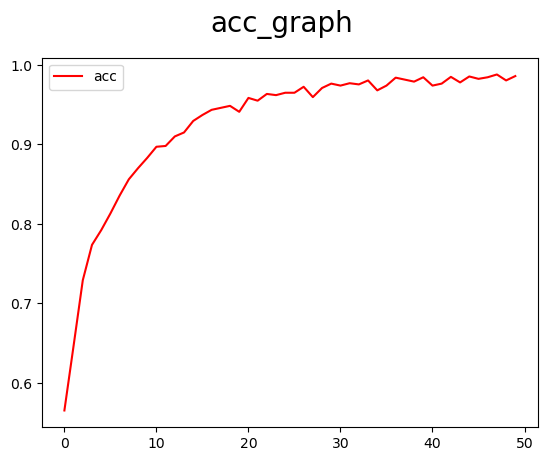

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure()
#plt.plot(hist.history['val_accuracy'],color = 'orange',label = 'val_accs')
plt.plot(hist.history['accuracy'],color = 'red',label = 'acc')
fig.suptitle('acc_graph',fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

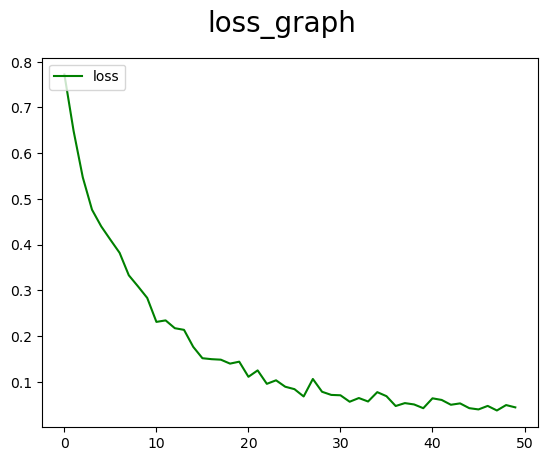

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(hist.history['loss'],color = 'green',label = 'loss')
#plt.plot(hist.history['val_loss'],color = 'cyan',label = 'val_loss')
fig.suptitle('loss_graph',fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

In [14]:
result = model.evaluate(X_test, y_test)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.4111 - loss: 3.7764


In [16]:
import numpy as np
import pandas as pd
# read csv file
df3  = spark.read.csv("/user/hadoop/input_data/112x112_500_test_deepfake_images.csv")
df=df3.toPandas().values
# read pixels
images = np.array(df.iloc[:,1:])
labels = np.array(df.iloc[:,-1])
# select random number between 0 and 7172
index = 1222
# reshape 784 rows to 28 height x 28 width
sample_image = images[index,:].reshape(112,112)
# import plt for displaying image
from matplotlib import pyplot as plt
# plot image
plt.imshow(sample_image)
plt.axis('off')
# plot it's label
print(labels[index])
# save image
plt.savefig("./image{}_label{}".format(index,labels[index]))

24/04/12 12:49:29 WARN DAGScheduler: Broadcasting large task binary with size 1446.2 KiB


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [22]:
# Load libraries
from PIL import Image
import numpy as np

# Define the path to your image
image_path = r"/home/hadoop/Downloads/real_243.jpg"
# Load the image using PIL
new_image = Image.open(image_path).convert("L")  # Convert to grayscale

# Resize the image to 28x28 pixels
new_image = new_image.resize((112, 112), Image.ANTIALIAS)

# Convert the image to a NumPy array
new_image = np.array(new_image)

# Reshape the image to match the model's input format
new_image = new_image.reshape(1, 112, 112, 1)

# Normalize the pixel values
new_image = new_image / 255.0


/tmp/ipykernel_22409/1013173079.py:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  new_image = new_image.resize((112, 112), Image.ANTIALIAS)


In [23]:
prediction = model.predict(new_image)
predicted_digit = np.argmax(prediction)

if (predicted_digit==1):
    print("FAKE IMAGE")
else:
    print("REAL IMAGE")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
REAL IMAGE
